# Complex networks: theory and applications
## Assignment 2: epidemic processes

#### Andrea Senacheribbe

---

In [1]:
figpath="figures/"

In [2]:
import numpy as np
import scipy.sparse as sparse, scipy.sparse.csgraph as sgraph, scipy.sparse.linalg as slinalg
import matplotlib.pyplot as plt, matplotlib.cm as cm
from numba import jit, prange

## Input graph:

#### Social network graph
http://snap.stanford.edu/data/ego-Facebook.html

node $\rightarrow$ person   
edge $\rightarrow$ friendship

In [ ]:
!wget -N http://snap.stanford.edu/data/facebook_combined.txt.gz
!gunzip -c facebook_combined.txt.gz > facebook_combined.txt

In [4]:
input_file="facebook_combined.txt"

undirected=True

## Reading and processing the graph

In [5]:
edges=np.loadtxt(input_file, dtype=np.uint32, comments=['%', '#'])
edges=edges[edges[:, 0] != edges[:, 1]] #remove self loops

if np.min(edges)==1: # if nodes numbering starts from 1
    edges-=1

dim=np.max(edges)+1

in_graph=sparse.csr_matrix((np.ones(edges.shape[0],dtype=np.uint8),(edges[:, 0], edges[:, 1])), shape=(dim,dim), dtype=np.uint8)

if undirected: # make the matrix symmetric
    in_graph=in_graph+in_graph.T

del edges

The graph is rappresented with its **adjacency matrix** rappresented in **sparse row** format 

In [6]:
in_graph

<4039x4039 sparse matrix of type '<class 'numpy.uint8'>'
	with 176468 stored elements in Compressed Sparse Row format>

In [7]:
assert(np.sum(in_graph.diagonal())==0) #make sure no self loops

The graph may be disconnected, so we extract the **largest connected component**

In [8]:
c_cc,cc=sgraph.connected_components(in_graph)
max_cc=np.argmax(np.bincount(cc))
indices=np.where(cc==max_cc)[0]

graph=in_graph[indices,:][:, indices]

In [9]:
n=graph.shape[0]
m=graph.nnz/2

## Displaying some statistics about the graph


In [10]:
print("n =", n, "(vertices)") 
print("m =", m, "(edges)")

n = 4039 (vertices)
m = 88234.0 (edges)


Plot the **sparsity** of the **adjacency matrix**

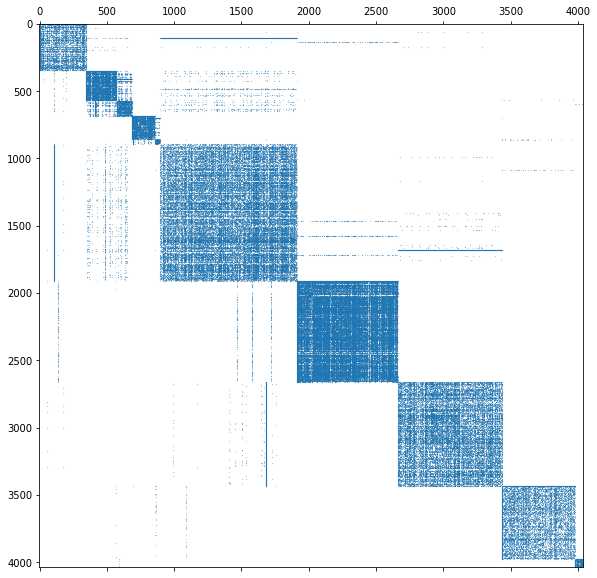

In [11]:
plt.figure(figsize=(10,10))
plt.spy(graph, markersize=.1)
plt.savefig(figpath+"sparsity.png")

## Simple model

In [12]:
@jit(nopython=True) #use JIT compilation to speedup execution time
def simple_epidemic(n, ia, ja, p, max_gen, starting):
    n_infected=np.zeros(max_gen+1)
    infected=np.zeros(n)
    
    #starting node
    g=0
    queue=[(starting, 0)]
    infected[starting]=1
    n_infected[0]=1
    
    while queue and g<=max_gen:
        v, g=queue.pop(0)
        for w in ja[ia[v]:ia[v + 1]]: # loop on neighbour of v
            if infected[w]==0 and np.random.sample()<p:
                infected[w]=1
                n_infected[g+1]+=1
                queue.append((w, g+1))
        
    return (np.cumsum(n_infected)/n, infected)

In [13]:
@jit(nopython=True, parallel=True)
def mc_simple(n, ia, ja, p, max_gen, starting=-1, n_rounds=1000):        
        
    n_infected=np.zeros(max_gen+1)
    infected=np.zeros(n)

    for i in prange(n_rounds):
        n_infected_c, infected_c = simple_epidemic(n, ia, ja, p, max_gen, starting) 
        n_infected+=n_infected_c
        infected+=infected_c
    
    return (n_infected/n_rounds, infected/n_rounds)

### Fix the starting point of the infection, vary p

plot the fraction of infected nodes with respect to generation


In [14]:
p_vals=[0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
starting=2300#np.random.randint(2000, 2500)
max_gen=15


print("infection starts in", starting)

infection starts in 2300


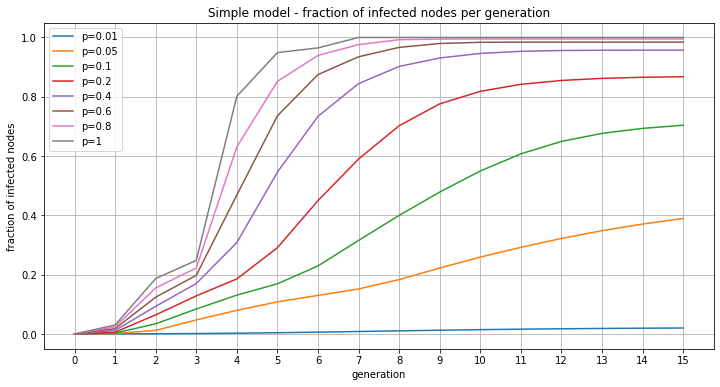

In [15]:
plt.figure(figsize=(12,6))

for p in p_vals:
    n_infected, infected=mc_simple(n, graph.indptr, graph.indices, p=p, max_gen=max_gen,starting=starting, n_rounds=1000)
    plt.plot(n_infected)
    
plt.legend(["p="+str(p) for p in p_vals])
plt.xlabel("generation")
plt.ylabel("fraction of infected nodes")
plt.title("Simple model - fraction of infected nodes per generation")
plt.grid(True)
plt.xticks(np.arange(max_gen+1));
plt.savefig(figpath+"simple.pdf")

### Fix the starting point of the infection, fix p=0.1 

plot probability node is infected

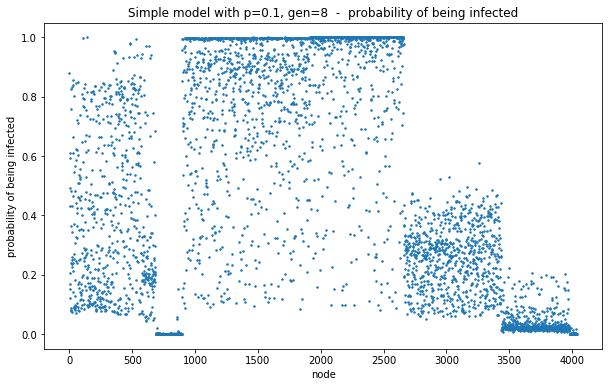

In [16]:
p=0.1
max_gen=8

plt.figure(figsize=(10,6))

n_infected, infected=mc_simple(n, graph.indptr, graph.indices, p=p, max_gen=max_gen, starting=starting, n_rounds=1000)
plt.plot(infected, '.', markersize=3);
plt.title("Simple model with p="+str(p)+", gen="+str(max_gen)+"  -  probability of being infected")
plt.xlabel("node")
plt.ylabel("probability of being infected")
plt.savefig(figpath+"probability.pdf")

## Bootstrap percolation

In [17]:
@jit(nopython=True) #use JIT compilation to speedup execution time
def bootstrap_percolation(n, ia, ja, r, max_gen, starting):
    n_infected=np.zeros(max_gen+1)
    infected=np.zeros(n)
    pressure=np.zeros(n)

    #starting node
    g=0
    queue=[(i, 0) for i in starting]
    infected[starting]=1
    n_infected[0]=starting.size
    
    
    while queue and g<=max_gen:
        v, g=queue.pop(0)

        for w in ja[ia[v]:ia[v + 1]]: # loop on neighbour of v
            pressure[w]+=1
            if infected[w]==0 and pressure[w]>=r:
                infected[w]=1
                n_infected[g+1]+=1
                queue.append((w, g+1))
        
    return (np.cumsum(n_infected)/n, infected)

In [18]:
starting=np.array([2321, 2035, 2231, 2008, 2270, 2046, 2267, 2194, 2423, 2316]) #np.random.choice(np.arange(2000, 2500), size=10, replace=False)
starting

array([2321, 2035, 2231, 2008, 2270, 2046, 2267, 2194, 2423, 2316])

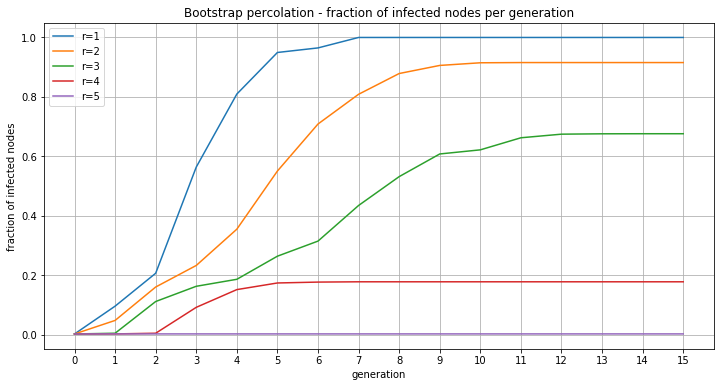

In [19]:
plt.figure(figsize=(12,6))

r_vals=[1, 2, 3, 4, 5]
max_gen=15

for r in r_vals:
    n_infected, infected=bootstrap_percolation(n, graph.indptr, graph.indices, r, max_gen, starting)
    plt.plot(n_infected)

plt.legend(["r="+str(r) for r in r_vals])
plt.xlabel("generation")
plt.ylabel("fraction of infected nodes")
plt.title("Bootstrap percolation - fraction of infected nodes per generation")
plt.grid(True)
plt.xticks(np.arange(max_gen+1));
plt.savefig(figpath+"bootstrap.pdf")

### Fix the starting point of the infection, fix r=5 

plot probability node is infected

Text(0, 0.5, 'probability')

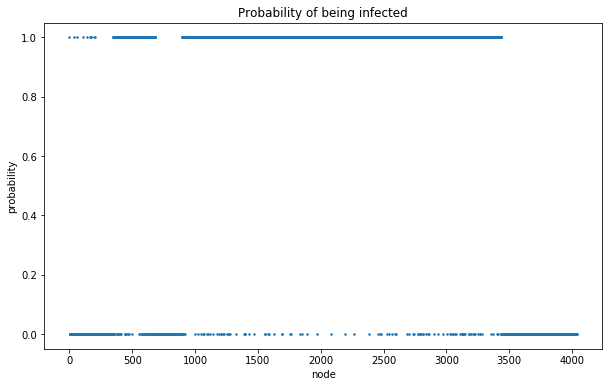

In [20]:
n_infected, infected=bootstrap_percolation(n, graph.indptr, graph.indices, 3, max_gen, starting)
plt.figure(figsize=(10,6))
plt.plot(infected, '.', markersize=3);
plt.title("Probability of being infected")
plt.xlabel("node")
plt.ylabel("probability")

## Bootstrap percolation with stochasticity

In [21]:
@jit(nopython=True) #use JIT compilation to speedup execution time
def bootstrap_probability(n, ia, ja, rp, max_gen, starting):
    n_infected=np.zeros(max_gen+1, dtype=np.uint)
    infected=np.zeros(n, dtype=np.uint)
    pressure=np.zeros(n, dtype=np.uint)

    #starting node
    g=0
    queue=[(i, 0) for i in starting]
    infected[starting]=1
    n_infected[0]=starting.size
    
    
    while queue and g<=max_gen:
        v, g=queue.pop(0)

        for w in ja[ia[v]:ia[v + 1]]: # loop on neighbour of v
            pressure[w]+=1
            if infected[w]==0 and (pressure[w]>rp.size or np.random.sample()< rp[pressure[w]-1]):
                infected[w]=1
                n_infected[g+1]+=1
                queue.append((w, g+1))
        
    return (np.cumsum(n_infected)/n, infected)

In [22]:
@jit(nopython=True, parallel=True)
def mc_bootstrap(n, ia, ja, rp, max_gen, starting=-1, n_rounds=1000):        
        
    n_infected=np.zeros(max_gen+1)
    infected=np.zeros(n)

    for i in prange(n_rounds):
        n_infected_c, infected_c = bootstrap_probability(n, ia, ja, rp, max_gen, starting)
        n_infected+=n_infected_c
        infected+=infected_c
    
    return (n_infected/n_rounds, infected/n_rounds)

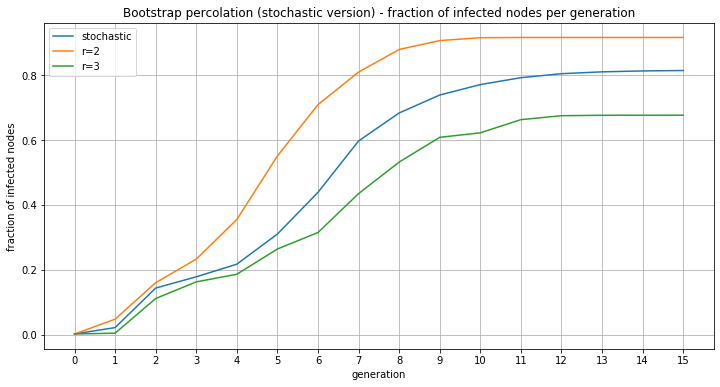

In [23]:
plt.figure(figsize=(12,6))

rp=np.array([0, 0.4])
r_vals=[2, 3]

n_infected, infected=mc_bootstrap(n, graph.indptr, graph.indices, rp, max_gen, starting, n_rounds=1000)
plt.plot(n_infected)

for r in r_vals:
    n_infected, infected=bootstrap_percolation(n, graph.indptr, graph.indices, r, max_gen, starting)
    plt.plot(n_infected)

plt.legend(["stochastic"]+["r="+str(r) for r in r_vals])

plt.xlabel("generation")
plt.ylabel("fraction of infected nodes")
plt.title("Bootstrap percolation (stochastic version) - fraction of infected nodes per generation")
plt.grid(True)
plt.xticks(np.arange(max_gen+1));
plt.savefig(figpath+"bootstrap_stoc.pdf")